# Coronory Artery Disease Project
## Exploratory analysis
### Prediction of heart disease given 14 variables

For this analysis we use the Cleveland "Coronary Artery Disease" dataset found on the UCI Machine Learning Repository
at the following location:

<a href=https://archive.ics.uci.edu/ml/datasets/Heart+Disease>Heart Disease Dataset</a>

The objective of the analysis is to use statistical learning to identify factors associated with Coronary Artery
Disease as indicated by a coronary angiography interpreted by a Cardiologist.

According to the paper by (Detrano et al., 1989) the data represents data collected for 303 patients referred for
coronary angiography at the Cleveland Clinic between May 1981 and September 1984. The 13 independent/ features
variables can be divided into 3 groups as follows:

Routine evaluation (based on historical data):
* ECG at rest
* Serum Cholesterol
* Fasting blood sugar

Non-invasive test data (informed consent obtained for data as part of research protocol):
* Exercise ECG
    * ST-segment peak slope (upsloping, flat or downsloping)
    * ST-segment depression
* Excercise Thallium scintigraphy (fixed, reversible or none)
* Cardiac fluoroscopy (number of vessels appeared to contain calcium)

Other demographic and clinical variables (based on routine data):
* Age
* Sex
* Chest pain type
* Systolic blood pressure
* ST-T-wave abnormality (T-wave abnormality)
* Probably or definite ventricular hypertrophy (Este's criteria)

The dependent/ response variable was the angiographic test result indicating a >50% diameter narrowing.

Detrano et al created 352 logistic regression models based on different combinations of the previously discussed
13 variables. Depending on information available in the test dataset one of these models was applied during model
validation.

Unfortunately the the paper by (Detrano et al., 1989) does not publish extensive model accuracy results such as:
overall accuracy, C-Statistic, precision (positive predictive value), recall (sensitivity) or specificity. The
model was however validated on various external datasets which is very important. The positive predictive value
(precision) is reported for a range of probability cut-off points for the various test sets. The various data sets
have widely varying prevalence (38% - 81%), and hence te positive predictive value likewise varies widely between the
reported tests.

From these results one can see that the model was capable of a Precision of approximately 75% for datasets closely
matching the Cleveland dataset in terms of disease prevalence within the test set.

We are going to replicate the analysis by performing a logistic regression and will perform a validation study to
confirm results obtained by (Detrano et al., 1989) in terms of model accuracy. Furthermore we will do an analysis of
significance of the various logistic regression features as means of classifying feature importance.

Subsequent to this analysis we will use an ensemble model (Random Forest) to create feature importance classifications
to validate the regression findings. We will also apply our learnings to a Neural Network, to assess performance on
the smaller dataset i.e. after features selection has been applied.

We aim to achieve this by following the Machine Learning pipeline approach of deploying a variety of ML techniques to
build a predictive model and analyse its results. In the process we hope to gain valuable insights. The various steps
in the process are as follows (not necessarily in this order):

- Load data
- Prepare data
    - Clean data
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data
        - Feature selection/ importance analysis
- Build model
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model
    - Accuracy testing
- Analysis of results
    - Response curves
    - Accuracy analysis
    - Commentary

Let us start the analysis!

In [6]:
%load_ext autoreload
%autoreload 2

# Import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from visualization import plot_confusion_matrix, plot_roc_curve, plot_feature_importance, \
    plot_feature_importance_log, plot_feature_importance_dec, plotGrid, plotAge, plotContinuous, plotCategorical
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
import warnings

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'plot_confusion_matrix' from 'visualization' (c:\users\pc-1\documents\github\projects\cor_art_dis\src\visualization\__init__.py)

<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [ ]:
# Import data
df = pd.read_csv('../data/raw/processed.cleveland.data', header = None, names = ['age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol',
                'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint', 'ca_disease'], index_col=None,
                 usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sep=',', skipinitialspace=True)
df.head(20)
print(df.shape)

The dataset read from csv file has 303 rows and 14 columns.
The data dictionary specified that 303 rows and 75 columns existed.
We therefore have the same number of rows as the data dictionary, but 61 fewer columns...

We were lucky that the data was already pre-processed, and this can be observed from the subset of data displayed
appearing very clean. Hopefully not much further cleaning would be required.

We created a data dictionary for the data is as follows:

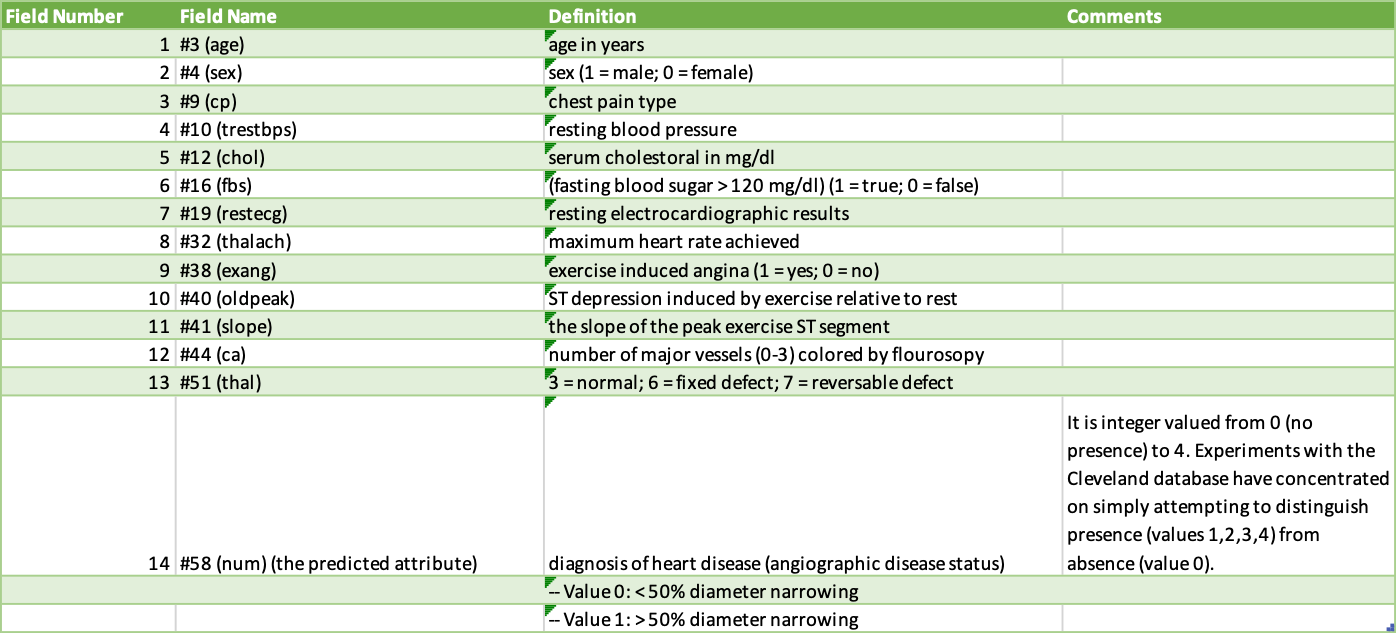

Let us explore the data!

<div class="alert alert-block alert-info">
<b>Clean data</b>
</div>

In [ ]:
# Type of data
print(df.info())

From the output we observe that we have twelve numeric columns and two "object" columns. The data dictionary
however specifies that all fields are numeric. This means that Python could not convert two numeric variables
(num_major_vessels and thallium_scint) to numeric columns due to their contents being non-numeric. Let us investigate.

In [ ]:
# Find out what types of data is stored in object column. Use simple regex. Leading number omitted not catered for.
# Future improvement.
r = re.compile(r'\d+[.,]\d*')
df.num_major_vessels.apply(lambda x: bool(r.match(x))).value_counts()
df.thallium_scint.apply(lambda x: bool(r.match(x))).value_counts()

df.loc[df.num_major_vessels.apply(lambda x: bool(r.match(x))) == False]
df.loc[df.thallium_scint.apply(lambda x: bool(r.match(x))) == False]

We can see that there are 4 non-numeric fields in num_major_vessels and 2 in thallium_scint. These values are all '?'.
It is a reasonable assumption that these are missing values from data entry due to the placeholder. We will therefore
clean the data by replacing these values with NaN and converting all character values to decimal.

In [ ]:
# Replace all non numeric data with NaN, convert strings to numbers.
df_clean = df.apply(pd.to_numeric, errors='coerce')

Let us see if that worked! We should now have only decimal and null values.

In [ ]:
# Number of null values
print(df_clean.isnull().sum())

# Actual null values
df_clean[df_clean.isnull().any(axis=1)]


Looks great we have 6 null values, 4 in num_major_vessels and 2 in thallium_scint as expected. We can also observe
that none of the other fields contain any null values. Seeing as there are only a handful of these values and none
in the response variable, it is not necessary to remove these records from the dataset at this stage.

We now have a dataset with 303 records and 14 numeric fields, as per the data dictionary, there are still 6 missing
values in the 'num_major_vessels' and 'thallium_scint' fields though. Due to the low number of missing values and even
distribution of values in these fields (see explore analysis below) we will now substitute these with median values.

In [ ]:
df_fin = df_clean.copy()
median = df_fin['num_major_vessels'].median()
df_fin['num_major_vessels'].fillna(median, inplace=True)
print("Number of null values in num_major_vessels column: {}".format(df_fin['num_major_vessels'].isnull().sum()))

median = df_fin['thallium_scint'].median()
df_fin['thallium_scint'].fillna(median, inplace=True)
print("Number of null values in thallium_scint column: {}".format(df_fin['thallium_scint'].isnull().sum()))
print("Dataframe dimension: {}".format(df_fin.shape))

Now our set is finally ready for further analysis. We will now look at the distribution of variables and any possible
outliers or heavy tailed distributions.

<div class="alert alert-block alert-info">
<b>Explore data</b>
</div>

We start by looking at the number of unique records per variable.

In [ ]:
print(df_fin.nunique())

There are no columns with only one value. We therefore retain all columns for ML purposes as there is enough
variability to warrant using the data. Interesting to observe that there is also a fair amount of similarity in
the cholesterol measurements which is surprising. There are many variables with fewer than 10 levels which
could be considered as categorical. Based on our initial assessment of the data we will work with levels of measurement
for the data as follows:

- age (continuous)
- sex (binary)
- chest_pain_type (ordinal)
- rest_blood_press (continuous)
- cholesterol (continuous)
- fasting_blood_sugar (binary)
- rest_ecg (ordinal)
- max_heart_rate (continuous)
- exer_ind_angina (binary)
- st_depression (continuous)
- st_slope (ordinal)
- num_major_vessels (ordinal)
- thallium_scint (ordinal - needs reordering)
- ca_disease (binary - we will need to transform as there are actually 5 levels in the data)

At this point it seems as if the only nominal data is binary, which means we might not need any One Hot Encoding
initially. We will leave the ordinal data as is for the initial analysis.
Next we look at the distribution of the data.

We now extract data according levels of measurement first to ease analysis. We also rename the variables to enable
ease of interpretion.

In [ ]:
# Extract categorical variables for analysis.
df_fin_cat = df_fin.copy()
names_cat = ('sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exer_ind_angina', 'st_slope',
             'num_major_vessels', 'thallium_scint', 'ca_disease')
df_fin_cat = df_fin_cat.loc[:, names_cat]

# Extract continuous variables for analysis.
#df_fin.reset_index(drop=True, inplace=True)
df_fin_con = df_fin.copy()
names_con = ('age', 'rest_blood_press', 'cholesterol', 'max_heart_rate', 'st_depression')
df_fin_con = df_fin_con.loc[:, names_con]

# Plotting label dictionary
plot_cat = [('sex', ['female', 'male']),
              ('chest_pain_type', ['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic']),
              ('fasting_blood_sugar', ['fbs > 120mg', 'fbs < 120mg']),
              ('rest_ecg', ['normal', 'ST-T wave', 'left ventricular']),
              ('exer_ind_angina', ['yes', 'no']),
              ('st_slope', ['upsloping', 'flat', 'downsloping']),
              ('num_major_vessels', ['0', '1', '2', '3']),
              ('thallium_scint', ['normal', 'fixed defect', 'reversible defect']),
              ('ca_disease', ['No CA disease', 'CA disease'])]
plot_con = [('age', 'age in years'),
            ('rest_blood_press', 'blood pressure in mm Hg'),
              ('cholesterol', 'serum cholestoral in mg/d'),
              ('max_heart_rate', 'maximum heart rate achieved'),
              ('st_depression', 'ST depression by exercise relative to rest'),
              ('ca_disease', 'Coronary Artery disease')]

# Extract numeric variables for analysis.
df_fin.reset_index(drop=True, inplace=True)
df_fin_num = df_fin.copy()
names_num = ('age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
             'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint',
             'ca_disease')
df_fin_num = df_fin_num.loc[:, names_num]

Now let us consider the response variable.

In [ ]:
#outcome_counts = df_fin_cat.groupby('ca_disease').size()
outcome_counts = df_fin_cat['ca_disease'].value_counts()
print(outcome_counts)

# Plot outcome counts.
ax = sns.barplot(x=outcome_counts.index, y=outcome_counts.values, alpha=0.9)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
#ax.title.set_size(45)
ax.tick_params('y', labelsize = 20);
ax.tick_params('x', labelsize = 20);
plt.title('Frequency Distribution of Outcomes', fontsize=20)
plt.ylabel('Number of Occurrences')
plt.xlabel('Outcome')
plt.show();

All looks good here. No obvious issues with the data. The spread of the data is good for classification, as there are
a large number of positive cases. If one combines classes 1, 2, 3 and 4 as suggested there will be a fairly even split
between positive and negative outcomes.
Let us look at that.

In [ ]:
# Transform y variable
df_fin_cat['num_bin'] = df_fin['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

outcome_counts_bin = df_fin_cat['num_bin'].value_counts()
print(outcome_counts_bin)
ax = sns.barplot(x=outcome_counts_bin.index, y=outcome_counts_bin.values)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
#ax.title.set_size(45)
ax.tick_params('y', labelsize = 20);
ax.tick_params('x', labelsize = 20);
plt.title('Frequency Distribution of Outcomes', fontsize = 20)
plt.ylabel('Number of Occurrences')
plt.xlabel('Outcome')
plt.show();

As expected, we don't need to be concerned about imbalanced classes for this analysis.

Let us now consider the categorical variables.

In [ ]:
# Class level counts for categorical variables.
for variable in names_cat:
    print(df_fin_cat[variable].value_counts())

In [ ]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(3, 3, figsize=(25, 20));
for variable, subplot in zip(names_cat, ax.flatten()):
    subplot.xaxis.label.set_size(34)
    subplot.yaxis.label.set_size(34)
    subplot.tick_params('y', labelsize = 30);
    subplot.tick_params('x', labelsize = 30);
    cp = sns.countplot(x=df_fin_cat[variable], ax=subplot);
plt.tight_layout()

The data looks fine from a modelling perspective, apart from the fact that the 'thallium_scint' variable needs to be recoded.
The values are not coded in the correct order.

Next, let us consider the continuous variables.

In [ ]:
# 5 number summary.
df_fin_con.describe()

In [ ]:
# Continuous density plot
df_fin_num['ca_disease'] = df_fin_num['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

fig_continuous, axes = plt.subplots(nrows=len(plot_con)-1, ncols=2, figsize=(15, 22))
_ = plotGrid(isCategorical=False, categorical = plot_cat, continuous = plot_con, df=df_fin_num, axes=axes);

In [ ]:
for variable in names_con:
    skew = df_fin_con[variable].skew()
    print("Skewness value for {}: {}".format(variable, skew))


In [ ]:
# Boxplot of continuous variables
medianprops = {'color': 'magenta', 'linewidth': 2}
boxprops = {'color': 'black', 'linestyle': '-', 'linewidth': 4}
whiskerprops = {'color': 'black', 'linestyle': '-', 'linewidth': 4}
capprops = {'color': 'black', 'linestyle': '-', 'linewidth': 4}
flierprops = {'color': 'black', 'marker': 'x', 'markersize': 25}

_ = df_fin_con.plot(kind='box', subplots=True, figsize=(35, 25), layout=(2,3), fontsize = 50, medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops);

_ = plt.tight_layout();
_ = plt.show();

No surprises here with regards to the continuous feature variables. We are dealing with an older population here with
average age of 54 years old. There are a few outliers for high resting blood pressure with the distribution showing
a slight skew to the right. Likewise for cholesterol and st_depression, with these two showing even higher skewness. Conversely
max_heart_rate has outliers to left and slight skewness to left too. This makes sense, as higher values for the prior would
indicate poorer health, whereas lower values for max_heart_rate would indicate poorer health.

The distributions of the feature variables have varying scales, so standardisation would be required for ML purposes.
Seeing as we will not be running a regression, normalisation would not be required. Investigation into outliers is
recommended as it might reveal interesting facts and would improve the model performance if outliers were addressed.


<div class="alert alert-block alert-info">
<b>Build Naive Model - Baseline</b>
</div>

We start by splitting the response and the features.

In [ ]:
# Transform y variable
df_fin['ca_disease'] = df_fin['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

# Copy original dataset
df_fin_nn = df_fin.copy()

# Group response values to form binary response
y = df_fin_nn.loc[:, 'ca_disease']

# Split data into features (X) and response (y)
X = df_fin_nn.loc[:, ('age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope',
                   'num_major_vessels', 'thallium_scint')]

X.head()

# Put the response y into an array
y = np.ravel(y)

Split the data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))

We now build and test a naive logistic regression model - without any transformations or optimisations.

In [ ]:
# Initial model
logreg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
y_pred = logreg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

<div class="alert alert-block alert-info">
<b>Build Logistic Regression - Release 1</b>
</div>


Scale and transform variables

In [ ]:
# Transform thallium_scint variable
trans_thal = {3:0, 7:1, 6:2}
df_fin_nn = df_fin.replace({"thallium_scint": trans_thal})

# Re-extract transformed X features
X = df_fin_nn.loc[:, ('age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope',
                   'num_major_vessels', 'thallium_scint')]

# Rebuild training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale data
scaler = StandardScaler()

# Fit on training data set
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Apply to test data
X_test = scaler.transform(X_test)


We now build a logistic regression model with data scaled and transformed according to Exploratory Data Analysis
results.

In [ ]:
# Initial model
logreg = LogisticRegression(fit_intercept = False)

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
y_pred = logreg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

We observe a modest improvement in accuracy for the model with the data minimally transformed and scaled.
Model performance in terms of convergence has however however improved as previously the number of iterations before
convergence had to be increased to over 1000,000 which is no longer the case after the data has been scaled.


<div class="alert alert-block alert-info">
<b>Build Logistic Regression - Release 2</b>
</div>

We now perform feature selection in order to ascertain whether a smaller parsimonious model could be built with fewer
variables. As per the article by (Detrano et al., 1989) this could be useful from a practical perspective as not all
healthcare settings have all the variables to their disposal which necessitates the deployment of several complex
predictive models which is not practical from an operational perspective.

We will first perform correlation and regression tests on the data. These tests are best performed by considering
continuous and categoric variables separately due to the intrinsic difference in regression coefficient values
for these variables. We will then perform a few numeric methods on the full dataset and compare results.

We start by considering the continuous variables.

In [ ]:
# Pearson correlation plot.
correlations = df_fin_con.corr()
# Plot correlation matrix
#sns.set(font_scale=1);
fig = plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(correlations, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

We see that there is a very strong inverse correlation between maximum heart rate and age. This makes sense as one's
maximum heart typically decreases with age. We also see that there is a strong positive correlation between maximum
heart rate and both cholesterol and resting blood pressure. This too makes sense as high blood pressure and cholesterol
are typically indications poor health which would result in lower maximum heart rate.
Another observation of interest is the strong correlation between cholesterol and the depression induced by exercise in
the ECG during exercise. These variables could make strong combined predictors for a next iteration of the model.
For now we will continue with the variables as is and focus on feature selection.

The first method we use is to compare the relative importance of logistic regression coefficient values for all our
continuous variables. Scikit-learn does not implement feature importance measures for logistic regression. We
therefore make use of the statsmodel libraries' implementation.

In [ ]:
# Extract continuous and categorical variables for analysis.
X_con = df_fin_con.copy()
X_cat = df_fin_cat.loc[:,('sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exer_ind_angina', 'st_slope', 'num_major_vessels', 'thallium_scint')]

X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_con, y, random_state=0)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, random_state=0)

log_reg = sm.Logit(y_train_con, X_train_con)
log_result = log_reg.fit()

print(log_result.summary2())
features_con = np.array(names_con)
plot_feature_importance_log(fit = log_result, features = features_con)

From this analysis it can be seen that the only variables of significance are max_heart_rate and st_depression. The remainder of the
variables will be rejected based on their coefficient sizes.
I would have preferred a univariate comparison between all the features, but this is unfortunately quite cumbersome
to implement in a short space of time given the lack of support in scikit-learn.
Next we will however make use of scikit-learn's native feature extraction methods. The uni-variate Anova test
on continuous variables as implemented in SelectKBest function 'f_classif' will be used. Let's see what the results
are.

In [ ]:
# Feature extraction set to retain all - we want to see scores for all variables.
test = SelectKBest(score_func=f_classif, k=5)
fit_kbest = test.fit(X_train_con, y_train_con)
features_kbest = np.array(X_con.columns)
plot_feature_importance(fit = fit_kbest, features = features_kbest)

We will now consider the categorical variables. Again the SelectKBest method will be used, but this time the
Chi-Squared function 'chi2' will be used. Let's see what the results are.

In [ ]:
test_cat = SelectKBest(score_func=chi2, k='all')
fit_kbest_cat = test_cat.fit(X_train_cat, y_train_cat)
features_kbest_cat = np.array(X_cat.columns)
plot_feature_importance(fit = fit_kbest_cat, features = features_kbest_cat)

num_major_vessels, thal_scint and exer_ind_angina are all extremely strong predictors. chest_pain_type, st_slope and
sex also contribute to the overall classification. From this analysis the only non-significant variables are
rest_ecg and fasting_blood_sugar.

We have now analysed continuous at categorical data separately from a statistical perspective.
Before we make the final decision on what variables to drop, we will now consider an ML technique for deriving feature
importance i.e. Decision Trees and Random Forests. Unlike the case of regression, we can analyse and draw conclusions
on continuous and categorical data together.

In [ ]:
# Fit a Decision Tree to data - perform cross validation to obtain optimum value for hyperparameter used for pruning.
samples = [sample for sample in range(1,30)]
validation_scores = []
for sample in samples:
    classifier1 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier1, X=X_train, y=y_train, cv=5)
    validation_scores.append(score.mean())

# Obtain the minimum leaf samples with the highest validation score
samples_optimum = samples[validation_scores.index(max(validation_scores))]

# Create final classifier
classifier2 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier2 = classifier2.fit(X_train, y_train)

# Probability scores for test set
y_pred = classifier2.predict(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

In [ ]:
importances = np.array(classifier2.feature_importances_)
feature_list = np.array(X.columns)
plot_feature_importance_dec(fit = importances, features = feature_list)

In [ ]:
# Show the first few levels of the tree
_ = export_graphviz(classifier2, out_file='tree.dot',
                feature_names = X.columns,
                class_names = ['CAD', 'No CAD'],
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True);

In [ ]:
_ = call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

The model has weaker accuracy, and therefore the feature importance results are not very convincing.
We will next look at random forests to see if we can improve on the single tree's accuracy.

In [ ]:
rand_forest = RandomForestClassifier(max_depth=5)
rand_forest.fit(X_train, y_train)

# Probability scores for test set
y_pred = rand_forest.predict(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

In [ ]:
importances = np.array(rand_forest.feature_importances_)
feature_list = np.array(X.columns)
plot_feature_importance_dec(fit = importances, features = feature_list)

In [ ]:
estimator = rand_forest.estimators_[1]

# Show the first few levels of the tree
_ = export_graphviz(estimator, out_file='tree.dot',
                feature_names = X.columns,
                class_names = ['CAD', 'No CAD'],
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True);

In [ ]:
_ = call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

We now build our final Logistic Regression model with the variables selected.

In [ ]:
# Extract continuous and categorical variables for analysis.
X_fin_cat = df_fin_cat.loc[:,('sex', 'chest_pain_type', 'exer_ind_angina', 'st_slope', 'num_major_vessels', 'thallium_scint')]
X_fin_con = df_fin_con.loc[:,('max_heart_rate', 'st_depression')]
X_final = pd.concat([X_fin_cat, X_fin_con], axis=1)

X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X_final, y, random_state=0)

# Scale data
scaler = StandardScaler()

# Fit on training data set
scaler.fit(X_train_fin)
X_train_fin = scaler.transform(X_train_fin)

# Apply to test data
X_test_fin = scaler.transform(X_test_fin)

# Final model
logfin = LogisticRegression(fit_intercept = False)

# Probability scores for test set
y_score_fin = logfin.fit(X_train_fin, y_train_fin).decision_function(X_test_fin)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_fin, y_score_fin)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
y_pred_fin = logfin.predict(X_test_fin)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred_fin, y_test_fin)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

The accuracy results indicate that even though 5 variables were dropped, the model accuracy did not reduce by
a significant amount. We can therefore confidently deploy this model with the knowledge that it is both robust and
accurate.


<div class="alert alert-block alert-info">
<b>Build Model 2 - Multi-Layer Perceptron</b>
</div>

We can now build a Multi Layer Perceptron to compare with the Logistic Regression.

MSE before model optimisation

In [ ]:
# Fit and check MSE before regularisation
reg = MLPClassifier(max_iter=50000, solver="adam", activation="tanh", hidden_layer_sizes=(5, 5), random_state=1)
reg.fit(X_train_fin, y_train_fin)

# Predict
y_pred_fin = reg.predict(X_test_fin)

# Accuracy before model parameter optimisation
accuracy_score(y_pred_fin, y_test_fin)

We now optimise the NN architecture.

In [ ]:
# Optimise numbers of nodes on both layers
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(3,6) for j in range(3,6)]:

    reg = MLPClassifier(max_iter=1000000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train_fin, y=y_train_fin, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

In [ ]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )

Now we optimise neural network regularisation parameter

In [ ]:
# Select range over which to find regularisation parameter - exponential used for even distribution of values
reg_par = [np.e**n for n in np.arange(-2,4,0.5)]

validation_scores = {}
print(" alpha  |  Accuracy")
for param in reg_par:
    reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size, alpha=param,
                        random_state=1)
    score = cross_val_score(estimator=reg, X=X_train_fin, y=y_train_fin, cv=2, scoring="accuracy")
    validation_scores[param] = score.mean()
    print("%0.5f |  %s" % (param, score.mean()))

# Plot the accuracy function against regularisation parameter
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()));
plt.xlabel("Ln of alpha");
plt.ylabel("Accuracy");

The highest cross-validation accuracy score and hence the value to use for the `alpha` parameter is as follows.

In [ ]:
max_score = ([np.log(name) for name, score in validation_scores.items() if score==max(validation_scores.values())][0])

# Find lowest value.
print("The highest accuracy score is: %s" % (max(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" % max_score)

MSE after regularisation

In [ ]:
# Fit data with the best parameter
reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size,
                    alpha=np.e**(2), random_state=1)

reg.fit(X_train_fin, y_train_fin)

# Predict
y_pred = reg.predict(X_test_fin)

# Accuracy after model parameter optimisation
accuracy_score(y_pred_fin, y_test_fin)

<div class="alert alert-block alert-info">
<b>Analysis of results</b>
</div>

Plot response curves

In [ ]:
# Create X_design_vec, which contains the median of each respective column
X_design = X_final.copy()
X_design_vec = pd.DataFrame(X_design.median()).transpose()
X_design_vec.head()

In [ ]:
names_num = ('sex', 'chest_pain_type', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint')

for variable in names_num:
    # Set up a sequence for response variable to plot
    min_res = min(X.loc[:,variable])
    max_res = max(X.loc[:,variable])
    seq = np.linspace(start=min_res,stop=max_res,num=50)

    # Set up a list of moving resultants to plot
    to_predict = []
    for result in seq:
        X_design_vec.loc[0,variable] = result
        to_predict.append(X_design_vec.copy())

    # Convert back to dataframe
    to_predict = pd.concat(to_predict)

    # Scale and predict
    to_predict = scaler.transform(to_predict)
    predictions = reg.predict_proba(to_predict)

    # Plot
    _ = plt.plot(seq,predictions[:,1])
    _ = plt.xlabel(variable)
    _ = plt.ylabel("ca_disease")
    _ = plt.title("ca_disease vs " + variable)
    plt.show();

Our model is accurate enough to capture the directly proportionate relationship between several response variables
(in order of strength of association, based on response curve output):

- thallium_scint
- num_major_vessels
- st_slope
- st_depression
- exer_ind_angina
- chest_pain_type
- sex

and the inversely proportional relationship between:

- max_heart_rate

and the outcome of confirmed Coronary Artery Disease. This is a positive outcome, as it means the model as applied
to the validation dataset managed to capture the underlying signals in the data. We can therefore conclude that the
model generalises well and that its accuracy is sufficiently high for this model to be used based on the features
captured.

This makes sense if one takes into account that the first two variables:

- thallium_scint: Arteries found to be: 1. Normal 2. Reversible defect and 3. Fixed defect
- num_major_vessels: Number of major vessels (0-3) coloured by fluoroscopy

are by nature close to the definition of Coronary Artery Disease itself.

Accuracy analysis

In [ ]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

Given the similar levels of accuracy that both the Logistic and MLP models attained it will be up to clinical decision
makers to decide on the utility of these approaches. Given the confidence in the Gold Standard i.e. Angiography and the
consequences of incorrect diagnosis, it is unlikely that a test resulting in a sensitivity of 90% or less will be
considered as a replacement.
An understanding of the factors contributing to a positive Angiography test would however assist clinicians in deciding
when an Angiography might be necessary and what the likely outcome would be. This could assist in early intervention,
workup and planning.
This analysis identified the 8 most important features to consider which are: thallium_scint, num_major_vessels,
st_slope, st_depression, max_heart_rate, exer_ind_angina, chest_pain_type and sex.